<a href="https://colab.research.google.com/github/hursung1/FearNet/blob/master/FearNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class CIFAR100_IncrementalDataset(torchvision.datasets.CIFAR100):
    def __init__(self, 
                 source='./cifar100_data', 
                 train=True,
                 transform=None,
                 download=False,
                 classes=range(100)):
        
        super(CIFAR100_IncrementalDataset, self).__init__(source, 
                                                       train, 
                                                       transform, 
                                                       download=True)
        self.train = train

        if train:
            train_data = []
            train_labels = []
            for i in range(len(self.data)):
                if self.targets[i] in classes:
                    train_data.append(self.data[i].astype(dtype=np.float32))
                    train_labels.append(self.targets[i])
            
            self.TrainData = train_data
            self.TrainLabels = train_labels

        else:
            test_data = []
            test_labels = []
            for i in range(len(self.data)):
                if self.targets[i] in classes:
                    test_data.append(self.data[i].astype(dtype=np.float32))
                    test_labels.append(self.targets[i])
            
            self.TestData = test_data
            self.TestLabels = test_labels

    def __getitem__(self, index):
        if self.train:
            return self.TrainData[index], self.TrainLabels[index]
        else:
            return self.TestData[index], self.TestLabels[index]

    def __len__(self):
        if self.train:
            return len(self.TrainLabels)
        else:
            return len(self.TestLabels)

In [0]:
# Hyperparameters
batch_size = 450

# standardization
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

TrainDataLoaders = []
TestDataLoaders = []

for i in range(10):
    # CIFAR100 Dataset
    TrainDataSet = CIFAR100_IncrementalDataset(source='data/',
                                               train=True,
                                               transform=transform,
                                               download=True,
                                               classes=range(i * 10, (i+1) * 10))
    
    TestDataSet = CIFAR100_IncrementalDataset(source='data/', 
                                              train=False,
                                              transform=transform,
                                              download=True,
                                              classes=range(i * 10, (i+1) * 10))
    
    TrainDataLoaders.append(torch.utils.data.DataLoader(TrainDataSet,
                                                        batch_size=batch_size,
                                                        shuffle=True))
    
    TestDataLoaders.append(torch.utils.data.DataLoader(TestDataSet, 
                                                       batch_size=batch_size,
                                                       shuffle=False))


Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


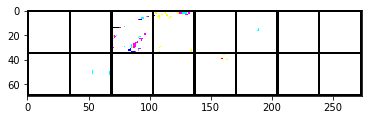

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


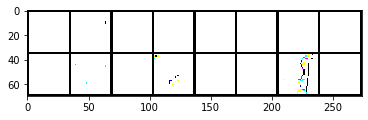

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


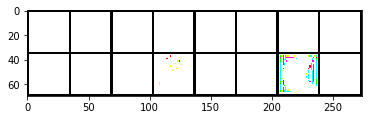

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


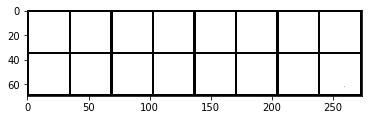

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


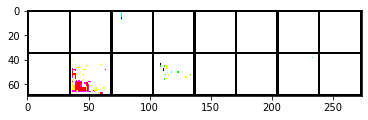

In [0]:
def imshow(img):
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()

def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    #img = (img+1)/2
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(npimg)
    plt.show()
    
for i in range(5):
    example_mini_batch_img, example_mini_batch_label  = next(iter(TrainDataLoaders[i]))
    #print(example_mini_batch_img[0].type(torch.uint8))
    #imshow(example_mini_batch_img[0].type(torch.uint8))
    example_mini_batch_img = example_mini_batch_img.permute(0, 3, 2, 1)
    print(example_mini_batch_img.shape)
    imshow_grid(example_mini_batch_img[0:16,:,:].view(16, -1, 32, 32))

torch.Size([100, 3, 32, 32])


TypeError: ignored

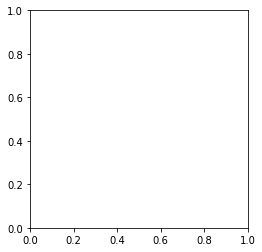

In [0]:
dataiter = iter(TrainDataLoaders[2])
image, label = dataiter.next()
image = image.permute(0,3, 2, 1)
print(image.shape)
imshow(image[0].type(torch.uint8))
print(label[0])

In [0]:
class Hippocampal():
    def __init__(self, task_num, eps):
        self.images = []
        self.labels = []

        self.task_num = task_num
        self.eps = eps


    def distillate(self, dataloader):
        assert dataloader is torch.utils.data.dataloader.DataLoader
        for data in dataloader:
            image, label = data
            if torch.cuda.is_available():
                image = image.cuda()
                label = label.cuda()

            self.images.append(image)
            self.labels.append(label)

        self.images = torch.cat(self.images)
        self.labels = torch.cat(self.labels)

        if torch.cuda.is_available():
            self.images = self.images.cuda()
            self.labels = self.labels.cuda()


    def forward(self, x):
        beta = torch.zeros((100))
        if torch.cuda.is_available():
            beta = beta.cuda()

        for i, image in enumerate(self.images):
            label = self.labels[i]
            norm = self.eps + (x - image).pow(2).sum().sqrt().item()
            if beta[label] > norm:
                beta[label] = norm

        beta = 1 / beta
        beta = beta / beta.sum()

        return beta 

In [0]:
# autoencoder
class mPFCEncoder(torch.nn.Module):
    def __init__(self):
        super(mPFC_encoder, self).__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(3, 12, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(12, 24, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(24, 48, 4, stride=2, padding=1)
        )

        if cuda_available:
            self.net = self.net.cuda()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


class mPFCDecoder(torch.nn.Module):
    def __init__(self):
        super(mPFC_decoder, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)
        )

        if torch.cuda.is_available():
            self.net = self.net.cuda()

    def forward(self, x):
        pass


In [0]:
class BLA():
    def __init__(self):
        pass

    def forward(self, x):
        pass

In [0]:
BKnet = torchvision.models.resnet18() # Base-Knowledge network
if torch.cuda.is_available():
    BKnet = BKnet.cuda()
    
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(BKnet.parameters(), lr=0.001)

BKnet.train()
trainloader = TrainDataLoaders[0]

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        image, label = data
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()

        #print(image.shape)
        image = image.permute(0, 3, 2, 1)
        optim.zero_grad()
        #print(image.shape)
        output = BKnet(image)
        loss = criterion(output, label)
        loss.backward()
        optim.step()

        running_loss += loss.item()

    #if i % 10 == 9:
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / 2000))

[Epoch 1] loss: 0.019
[Epoch 2] loss: 0.009
[Epoch 3] loss: 0.007
[Epoch 4] loss: 0.006
[Epoch 5] loss: 0.005
[Epoch 6] loss: 0.004
[Epoch 7] loss: 0.004
[Epoch 8] loss: 0.003
[Epoch 9] loss: 0.002
[Epoch 10] loss: 0.002


In [0]:
class_correct = [0.0 for i in range(10)]
class_total = [0 for i in range(10)]

BKnet.eval()
testloader = TestDataLoaders[0]

for data in testloader:
    x, y = data
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    x = x.permute(0, 3, 2, 1)
    output = BKnet(x)
    _, predicted = torch.max(output, 1)
    c = (predicted == y).squeeze()

    for i in range(y.shape[0]):
        label = y[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
print(class_total)

for i in range(10):
    print('Accuracy of class %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Accuracy of class     0 : 92 %
Accuracy of class     1 : 63 %
Accuracy of class     2 : 33 %
Accuracy of class     3 : 66 %
Accuracy of class     4 : 31 %
Accuracy of class     5 : 66 %
Accuracy of class     6 : 27 %
Accuracy of class     7 : 55 %
Accuracy of class     8 : 65 %
Accuracy of class     9 : 66 %


In [0]:
HC = Hippocampus()
mpfc_enc = mPFCEncoder()
mpfc_dec = mPFCDecoder()

num_class = 10

for i in range(1, num_class):
    HC.distillate(TrainDataLoaders[i])
    mpfc_enc.
    